# Models


# Model 4

- get_dummies categorical data.
- perform undersampling with NearMiss.

## Import libraries/packages

In [15]:
### General libraries ###
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import graphviz 
from graphviz import Source
from IPython.display import SVG
import os

##################################

### ML Models ###
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree.export import export_text
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.feature_selection import SelectKBest

##################################

### Metrics ###
from yellowbrick.classifier import ConfusionMatrix
from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, roc_auc_score, roc_curve, precision_score, recall_score

## Part 1: Load and clean the data

In [2]:
# Load the data.
file = 'car.csv'
data = pd.read_csv(file)

# Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying       1728 non-null object
maint        1728 non-null object
doors        1728 non-null object
persons      1728 non-null object
lug_boot     1728 non-null object
safety       1728 non-null object
class_val    1728 non-null object
dtypes: object(7)
memory usage: 94.6+ KB


In [3]:
# Shape of the data set.
print("The data set has {} rows and {} columns.".format(
    data.shape[0], data.shape[1]))

The data set has 1728 rows and 7 columns.


In [4]:
# Check for missing values.
data.isna().any()

buying       False
maint        False
doors        False
persons      False
lug_boot     False
safety       False
class_val    False
dtype: bool

In [5]:
# Check for duplicate rows.
data.duplicated().any()

False

In [6]:
# Checking the values from each column.
for col in data.columns:
    print("Column:", col)
    print(data[col].value_counts(), '\n')

Column: buying
high     432
vhigh    432
med      432
low      432
Name: buying, dtype: int64 

Column: maint
high     432
vhigh    432
med      432
low      432
Name: maint, dtype: int64 

Column: doors
3        432
4        432
2        432
5more    432
Name: doors, dtype: int64 

Column: persons
4       576
2       576
more    576
Name: persons, dtype: int64 

Column: lug_boot
small    576
big      576
med      576
Name: lug_boot, dtype: int64 

Column: safety
high    576
med     576
low     576
Name: safety, dtype: int64 

Column: class_val
unacc    1210
acc       384
good       69
vgood      65
Name: class_val, dtype: int64 



In [7]:
# Plotting the values of each column.
for i in data.columns:
    labels = data[i].unique()
    values = data[i].value_counts()
    fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
    fig.update_layout(title=go.layout.Title(
        text='Value distribution for column: "{}"'.format(i), x=.5))
    fig.show()

Since all the columns are categorical, we change the data types to "category". This will come in handy in case we want to sort any column of the data set.

## Part 2: Preprocessing

In this part we prepare our data for our models. This means that we choose the columns that will be our independed variables and which column the class that we want to predict. Once we are done with that, we split our data into train and test sets and perfom a standardization upon them.

In [8]:
# The data set after the conversion.
data.head()

buying  maint doors persons lug_boot safety class_val
0  vhigh  vhigh     2       2    small    low     unacc
1  vhigh  vhigh     2       2    small    med     unacc
2  vhigh  vhigh     2       2    small   high     unacc
3  vhigh  vhigh     2       2      med    low     unacc
4  vhigh  vhigh     2       2      med    med     unacc

In [9]:
# Choose attribute columns and class column.
X = data[data.columns[:-1]]
y = data['class_val']

In [10]:
# OneHot encoder for all the features.
X = pd.get_dummies(X)

# Label encoder for 'class_val'
y = y.replace({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})

## Feature selection

In [11]:
def find_best_k(X, y, tol=0.001, n_iter_no_change=10, n_clusters=2, verbose=False):
    from sklearn.feature_selection import SelectKBest
    scores = []
    n_features = len(X.columns)
    no_improvement_counter = 0
    best_validation_score_ = -np.inf

 # Main loop
    for kappa in range(1, n_features+1):
        X_new = SelectKBest(k=kappa).fit_transform(X, y)
        sc = StandardScaler()
        sc.fit(X_new)
        X_new = sc.transform(X_new)
        X_new = pd.DataFrame(X_new)
        model = KMeans(n_clusters=2, random_state=25).fit(X_new)
        X_new['cluster'] = model.labels_
        X_train, X_test, y_train, y_test = train_test_split(
            X_new, y, test_size=0.3, random_state=25)
        # # Perform undersampling with NearMiss.
        nr = NearMiss()
        X_train, y_train = nr.fit_sample(X_train, y_train)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    # Initialize a Logistic Regression estimator.
        logreg = LogisticRegression(
            multi_class='auto', random_state=25, n_jobs=-1)
    # Train the estimator.
        logreg.fit(X_train, y_train)
        kappa_score = cross_val_score(logreg, X_new, y, cv=10).mean()
        scores.append(kappa_score)
        last_valid_score = scores[-1]
        
        if verbose:
            print(kappa, no_improvement_counter)
            print(scores)

        if last_valid_score < (best_validation_score_ + tol):
            no_improvement_counter += 1
        else:
            no_improvement_counter = 0

        if no_improvement_counter > n_iter_no_change:
            break

        if last_valid_score > best_validation_score_:
            best_validation_score_ = last_valid_score

    print(
        f'kappa: {scores.index(best_validation_score_)+1} with score: {best_validation_score_.round(3)}')

In [13]:
find_best_k(X, y, verbose=1, n_clusters=4)

1 0
[0.7002352466729399]
2 0
[0.7002352466729399, 0.7778968947439171]
3 0
[0.7002352466729399, 0.7778968947439171, 0.747153515257427]
4 1
[0.7002352466729399, 0.7778968947439171, 0.747153515257427, 0.7859524129587311]
5 0
[0.7002352466729399, 0.7778968947439171, 0.747153515257427, 0.7859524129587311, 0.7801720661379219]
6 1
[0.7002352466729399, 0.7778968947439171, 0.747153515257427, 0.7859524129587311, 0.7801720661379219, 0.7801720661379219]
7 2
[0.7002352466729399, 0.7778968947439171, 0.747153515257427, 0.7859524129587311, 0.7801720661379219, 0.7801720661379219, 0.7853743782766501]
8 3
[0.7002352466729399, 0.7778968947439171, 0.747153515257427, 0.7859524129587311, 0.7801720661379219, 0.7801720661379219, 0.7853743782766501, 0.7934466998252453]
9 0
[0.7002352466729399, 0.7778968947439171, 0.747153515257427, 0.7859524129587311, 0.7801720661379219, 0.7801720661379219, 0.7853743782766501, 0.7934466998252453, 0.7905161984137653]
10 1
[0.7002352466729399, 0.7778968947439171, 0.74715351525742

## Kmeans analysis

In [16]:
X = SelectKBest(k=18).fit_transform(X, y)

In [17]:
# Create a k-means model with k=4.
model = KMeans(n_clusters=4, random_state=25)

In [18]:
# Standardization
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X = pd.DataFrame(X)

In [19]:
X['cluster'] = model.fit_predict(X)

In [20]:
# Split to train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [21]:
# # Perform undersampling with NearMiss.
nr = NearMiss()
X_train, y_train = nr.fit_sample(X_train, y_train)

# Perform oversampling with SMOTE.
# smt = SMOTE()
# X_train, y_train = smt.fit_sample(X_train, y_train)

In [22]:
# Standardization
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## Part 3: Modeling

In this section we build and try 3 models:
 - Logistic Regression
 - Decision tree
 - Neural network



## Logistic Regression

In [23]:
# Initialize a Logistic Regression classifier.
logreg = LogisticRegression(
    solver='saga', multi_class='auto', random_state=42, n_jobs=-1)

# Train the classifier.
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [24]:
# Make predictions.
log_pred = logreg.predict(X_test)

# CV score
logreg_cv = cross_val_score(logreg, X, y, cv=10, n_jobs=-1)

## Metrics for Logistic Regression

In [25]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % logreg.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % logreg_cv.mean())

# Precision
print('Precision: %.3f' % precision_score(y_test, log_pred, average='macro'))

# Recall
print('Recall: %.3f' % recall_score(y_test, log_pred, average='macro'))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, log_pred, average='macro'))

Accuracy: 0.499
Cross-validation accuracy: 0.844
Precision: 0.671
Recall: 0.751
F1 score: 0.623


## Confusion Matrix for Logistic Regression

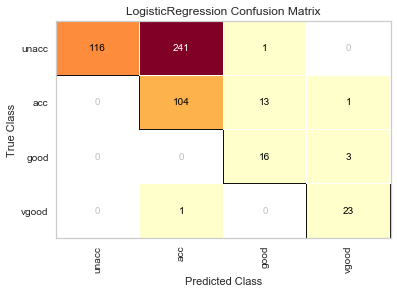

In [26]:
cm = ConfusionMatrix(logreg, classes=['unacc', 'acc', 'good', 'vgood'],
                     label_encoder={0: 'unacc', 1: 'acc', 2: 'good', 3: 'vgood'}, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

## Decision tree

In [27]:
# Initialize a decision tree estimator.
tr = tree.DecisionTreeClassifier(
    max_depth=30, criterion='gini', random_state=42)

# Train the estimator.
tr.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Text(0.5, 1.0, 'Decision Tree')

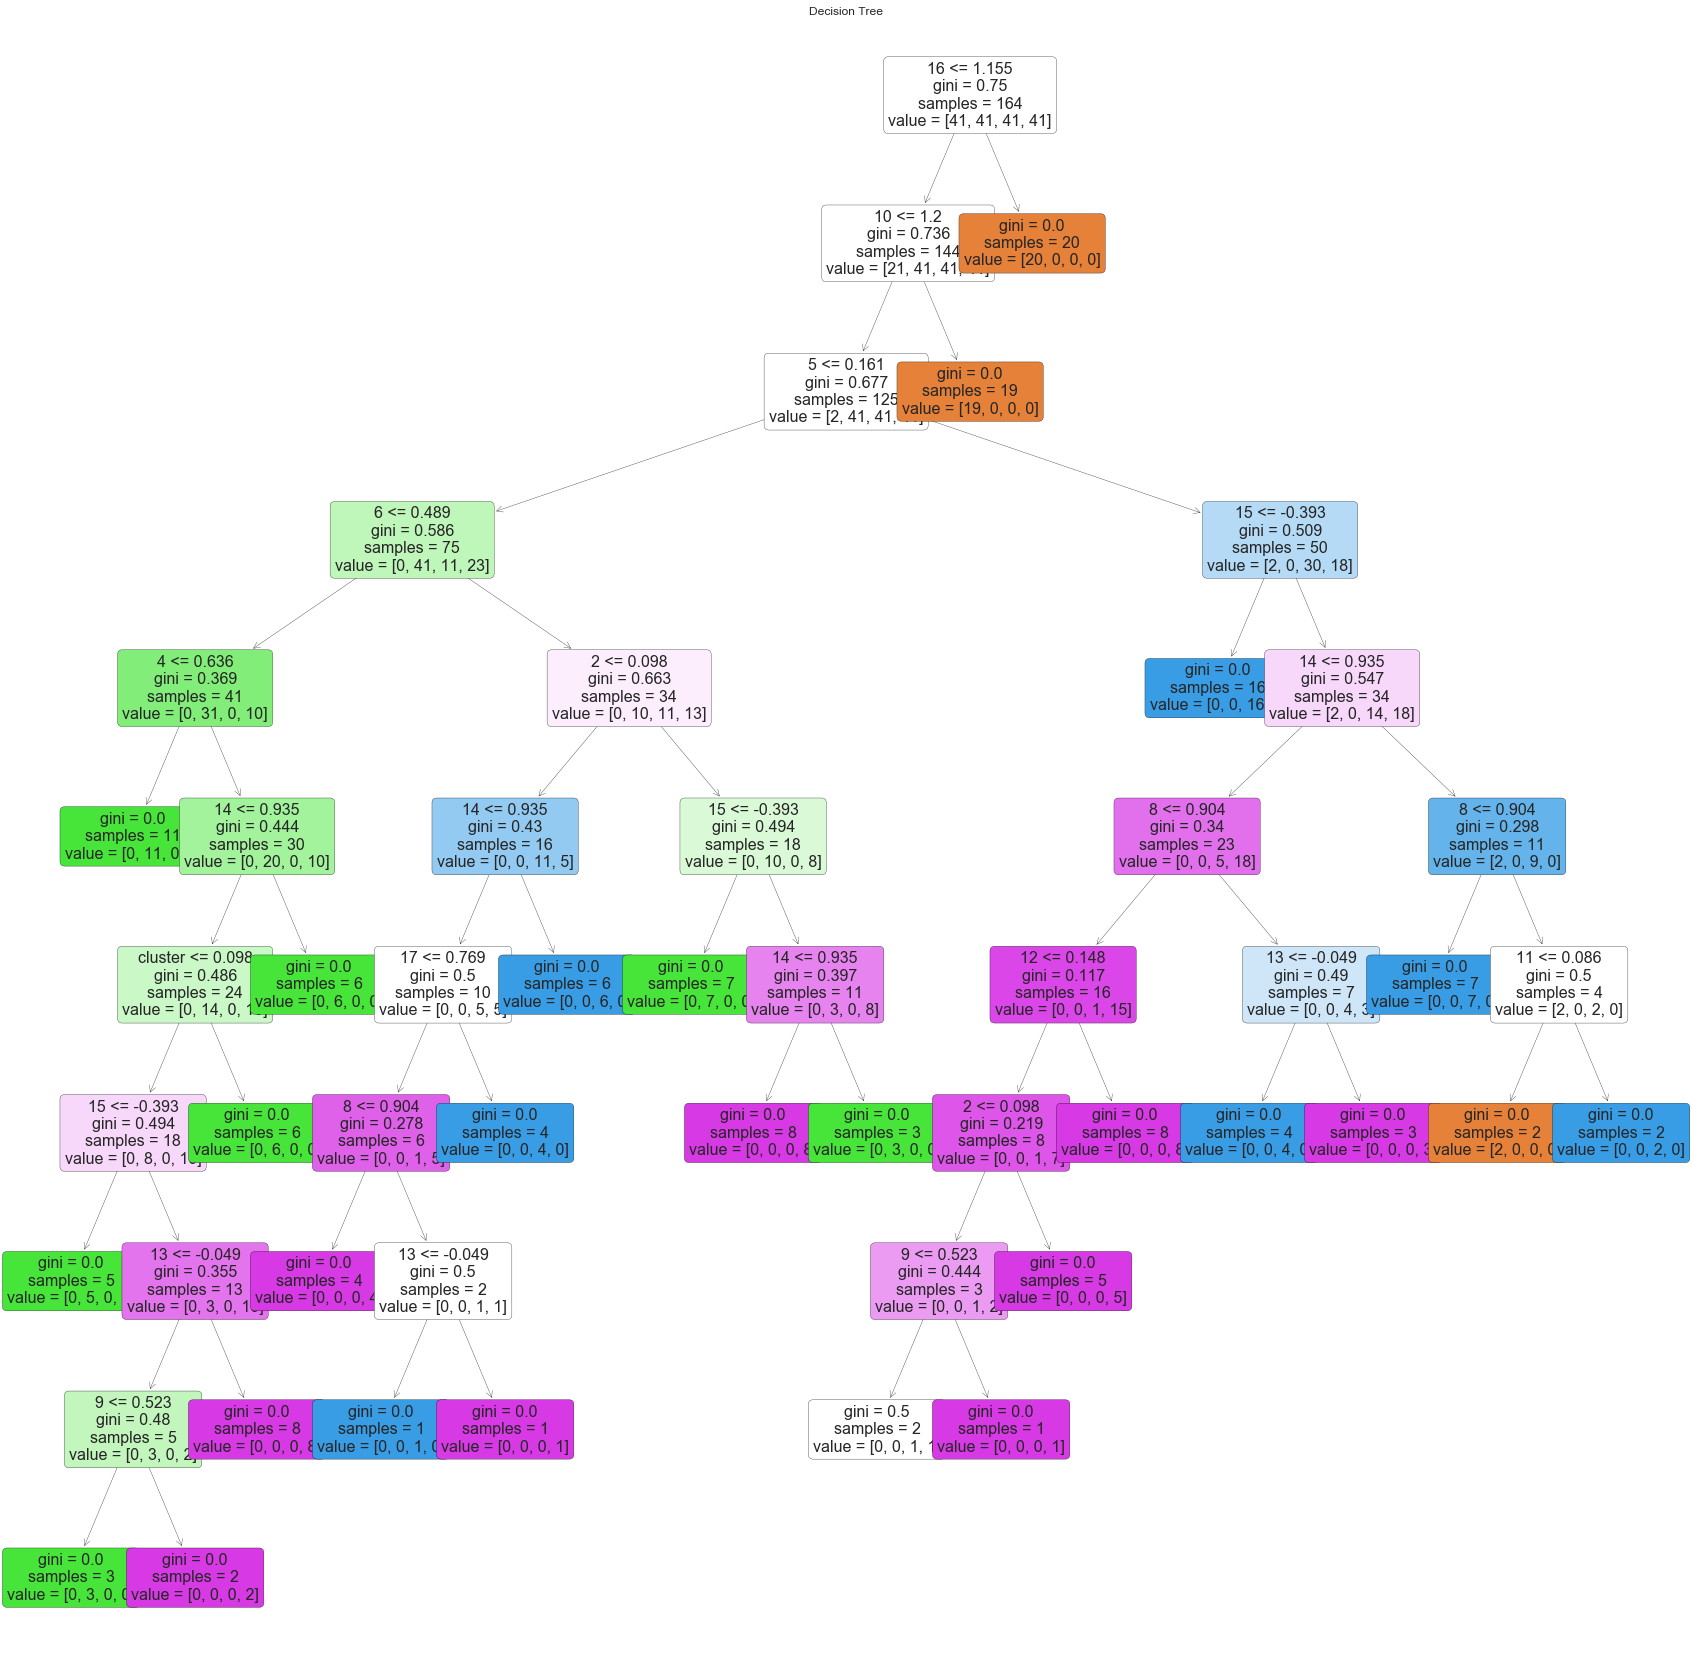

In [28]:
# Plot the tree.
fig = plt.figure(figsize=(30, 30))
tree.plot_tree(tr.fit(X_train, y_train), feature_names=X.columns,
               filled=True, rounded=True, fontsize=16)
plt.title('Decision Tree')

In [29]:
# Print the tree in a simplified version.
r = export_text(tr, feature_names=X.columns.tolist())
print(r)

|--- 16 <= 1.16
|   |--- 10 <= 1.20
|   |   |--- 5 <= 0.16
|   |   |   |--- 6 <= 0.49
|   |   |   |   |--- 4 <= 0.64
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- 4 >  0.64
|   |   |   |   |   |--- 14 <= 0.93
|   |   |   |   |   |   |--- cluster <= 0.10
|   |   |   |   |   |   |   |--- 15 <= -0.39
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- 15 >  -0.39
|   |   |   |   |   |   |   |   |--- 13 <= -0.05
|   |   |   |   |   |   |   |   |   |--- 9 <= 0.52
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- 9 >  0.52
|   |   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |   |--- 13 >  -0.05
|   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |--- cluster >  0.10
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- 14 >  0.93
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- 6 >  0.49
|   |   |   |   |--- 2 <= 0.10
|   |   |   |   |   |---

In [30]:
# Make predictions.
tr_pred = tr.predict(X_test)

# CV score
tr_cv = cross_val_score(tr, X, y, cv=10, n_jobs=-1)

## Metrics for Decision tree

In [31]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % tr.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % tr_cv.mean())

# Precision
print('Precision: %.3f' % precision_score(y_test, tr_pred, average='macro'))

# Recall
print('Precision: %.3f' % recall_score(y_test, tr_pred, average='macro'))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, tr_pred, average='macro'))

Accuracy: 0.751
Cross-validation accuracy: 0.876
Precision: 0.553
Precision: 0.754
F1 score: 0.593


## Confusion Matrix for Decision tree

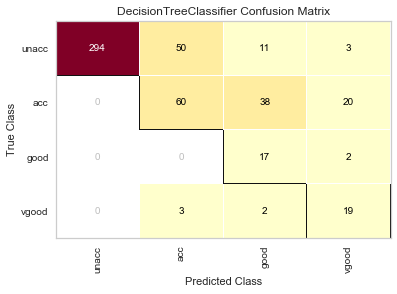

In [32]:
# Print confusion matrix for Decision tree.
cm = ConfusionMatrix(tr, classes=['unacc', 'acc', 'good', 'vgood'],
                     label_encoder={0: 'unacc', 1: 'acc', 2: 'good', 3: 'vgood'}, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

## Neural network (MLP)

In [45]:
# Initialize a Multi-layer Perceptron classifier.
mlp = MLPClassifier(hidden_layer_sizes=(5,5,5), max_iter=1000,
                    random_state=42, shuffle=True, verbose=False)

# Train the classifier.
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [46]:
# Make predictions.
mlp_pred = mlp.predict(X_test)

# CV score
mlp_cv = cross_val_score(mlp, X, y, cv=10, n_jobs=-1)

## Metrics for Neural Network (MLP)

In [47]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % mlp.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % mlp_cv.mean())

# Precision
print('Precision: %.3f' % precision_score(y_test, mlp_pred, average='macro'))

# Recall
print('Recall: %.3f' % recall_score(y_test, mlp_pred, average='macro'))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, mlp_pred, average='macro'))

Accuracy: 0.459
Cross-validation accuracy: 0.894
Precision: 0.599
Recall: 0.718
F1 score: 0.528


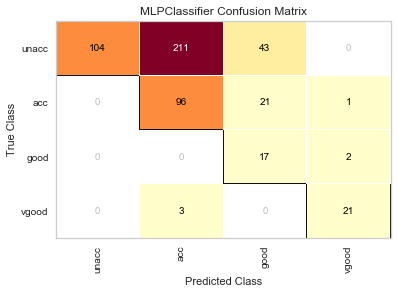

In [48]:
# Plot confusion matrix for MLP.
cm = ConfusionMatrix(mlp, classes=['unacc', 'acc', 'good', 'vgood'],
                     label_encoder={0: 'unacc', 1: 'acc', 2: 'good', 3: 'vgood'}, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

## Results

In [49]:
metrics = ['Accuracy', 'CV accuracy', 'Precision', 'Recall', 'F1', 'AUC']

# Plot metrics.
fig = go.Figure(data=[
    go.Bar(name='Logistic Regression', x=metrics,
           y=[logreg.score(X_test, y_test), logreg_cv.mean(), precision_score(y_test, log_pred, average='macro'), recall_score(y_test, log_pred, average='macro'), f1_score(y_test, log_pred, average='macro')]),
    go.Bar(name='Decision tree', x=metrics,
           y=[tr.score(X_test, y_test), tr_cv.mean(), precision_score(y_test, tr_pred, average='macro'), recall_score(y_test, tr_pred, average='macro'), f1_score(y_test, tr_pred, average='macro')]),
    go.Bar(name='Neural Network', x=metrics,
           y=[mlp.score(X_test, y_test), mlp_cv.mean(), precision_score(y_test, mlp_pred, average='macro'), recall_score(y_test, mlp_pred, average='macro'), f1_score(y_test, mlp_pred, average='macro')]),
])

fig.update_layout(title_text='Metrics for all models',
                  barmode='group', xaxis_tickangle=-45, bargroupgap=0.05)
fig.show()

In [50]:
d = {
    '': ['Logistic Regression', 'Decision Tree', 'Neural Network (MLP)'],
    'Accuracy': [logreg.score(X_test, y_test), tr.score(X_test, y_test), mlp.score(X_test, y_test)],
    'CV Accuracy': [logreg_cv.mean(), tr_cv.mean(), mlp_cv.mean()],
    'Precision': [precision_score(y_test, log_pred, average='macro'), precision_score(y_test, tr_pred, average='macro'), precision_score(y_test, mlp_pred, average='macro')],
    'Recall': [recall_score(y_test, log_pred, average='macro'), recall_score(y_test, tr_pred, average='macro'), recall_score(y_test, mlp_pred, average='macro')],
    'F1': [f1_score(y_test, log_pred, average='macro'), f1_score(y_test, tr_pred, average='macro'), f1_score(y_test, mlp_pred, average='macro')]
}

results = pd.DataFrame(data=d).round(3).set_index('')
results

Accuracy  CV Accuracy  Precision  Recall     F1
                                                                     
Logistic Regression      0.499        0.844      0.671   0.751  0.623
Decision Tree            0.751        0.876      0.553   0.754  0.593
Neural Network (MLP)     0.459        0.894      0.599   0.718  0.528

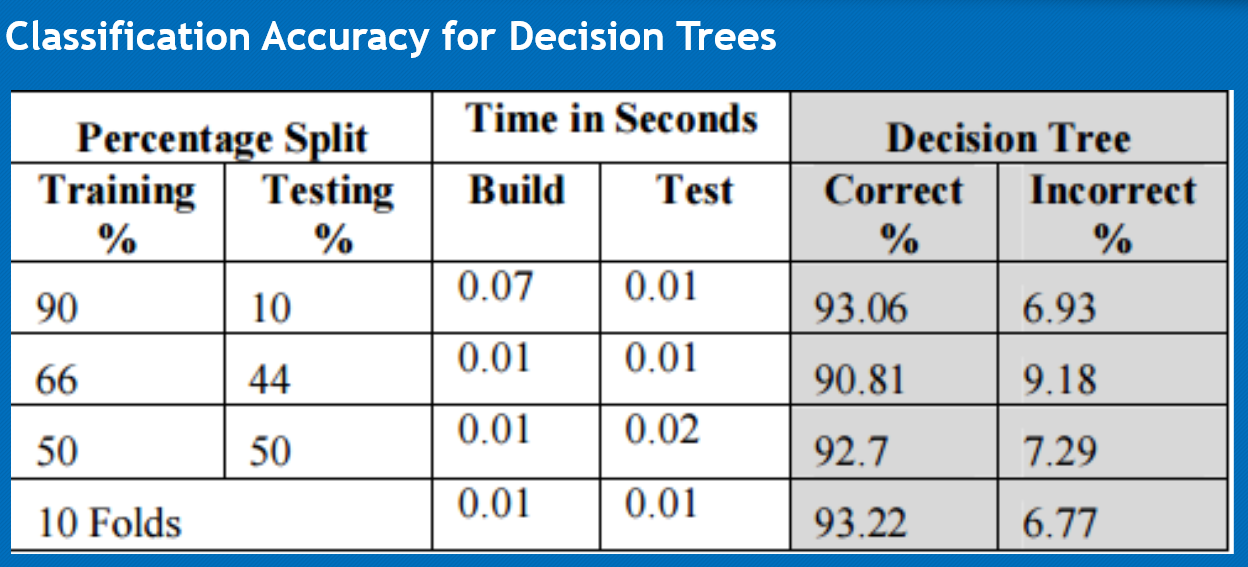

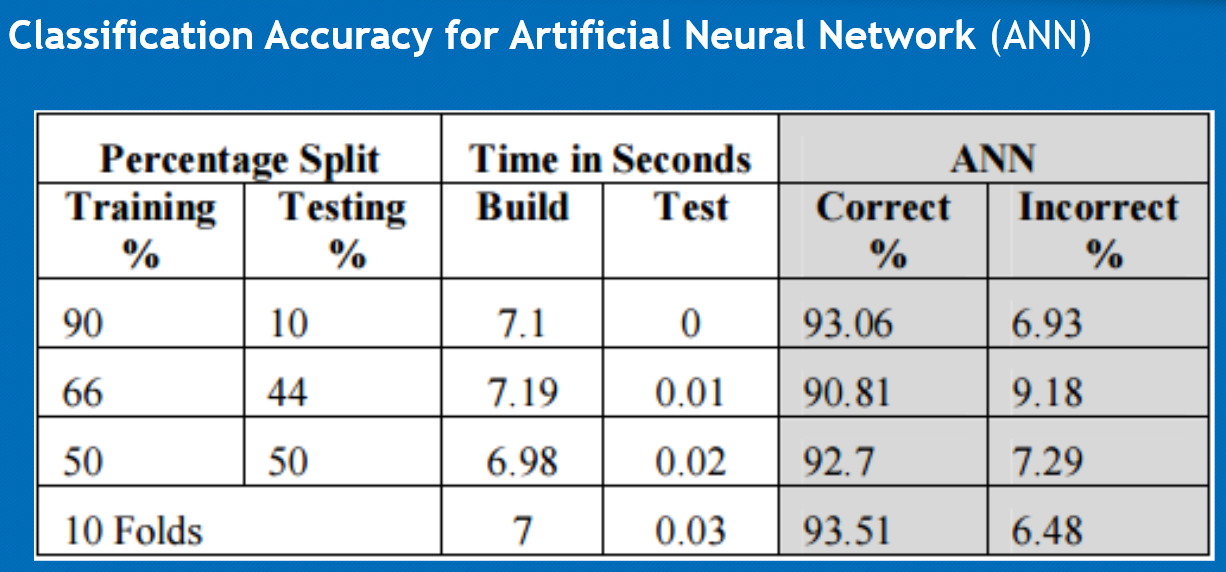

## Evaluating Performance

### Hypothesis Testing
- $H_{0}$: There is no significant difference in the test set error rate of two supervised learner models $M_{1}$ and $M_{2}$ built with the same training data.
- $H_{1}$: There is significant difference in the test set error rate of two supervised learner models $M_{1}$ and $M_{2}$ built with the same training data.

### Comparing models with a single test set

**Step 1.** (Initialization). Given:
- Two models, $M_{1}$ and $M_{2}$ built with the same training data.
- One test set $A$ with $card(A)=n$.
- Error rate $E_{1}$ for model $M_{1}$ on test set $A$.
- Error rate $E_{2}$ for model $M_{2}$ on test set $A$.

**Step 2.** Compute:  

$$P=\frac{|E_{1}-E_{2}|}{\sqrt{\frac{(v_{1}+v_{2})}{n}}}$$

**Step 3.** Conclude:  
If $P≥2$, hypothesis $H_{1}$ holds. Otherwise, $H_{0}$ is true.

In [51]:
from itertools import combinations

# Dictionary with all the classifiers.
models = {'LogisticRegression': logreg,
          'DecisionTreeClassifier': tr,
          'MLPClassifier': mlp
          }

def evaluating_performance2(models=None):
    if models == None:
        return 'No models to compare'
    else:
        for model in combinations(models.keys(), 2):
            E1 = models[model[0]].score(X_test, y_test)
            E2 = models[model[1]].score(X_test, y_test)
            var1 = E1*(1-E1)
            var2 = E2*(1-E2)
            n = len(X_test)
            P = abs(E1-E2)/np.sqrt((var1+var2)/n)
            print(
                f'Comparing Performance between {model[0]} and {model[1]}:', P.round(3))
            if P < 2:
                print(
                    f'There is no significant diferrence between {model[0]} and {model[1]}\n')
            else:
                print(
                    f'==>The models {model[0]} and {model[1]} are significant different<==\n')

evaluating_performance2(models)

Comparing Performance between LogisticRegression and DecisionTreeClassifier: 8.701
==>The models LogisticRegression and DecisionTreeClassifier are significant different<==

Comparing Performance between LogisticRegression and MLPClassifier: 1.306
There is no significant diferrence between LogisticRegression and MLPClassifier

Comparing Performance between DecisionTreeClassifier and MLPClassifier: 10.115
==>The models DecisionTreeClassifier and MLPClassifier are significant different<==



***